In [257]:
from __future__ import annotations
from typing import Optional, Tuple
import pandas as pd 
from copy import deepcopy
from scipy.stats.contingency import odds_ratio
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import itertools

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Loading**

In [258]:
# load to dataframe
INFILE = '/home/grace/work/SEER/data/SEERPLUS_2010_2020.clean.tsv'
master = pd.read_csv(INFILE, header=0, sep='\t', na_values='.')

In [ ]:
master[master['cancer_type']=='Pancreas']['n_stage_ajcc'].value_counts()

In [259]:
# basic formatting
from util_funcs import do_basic_formatting
HISTTYPES_PATH = '/home/grace/work/SEER/data/histology/histcodes.tsv'
df = do_basic_formatting(master, HISTTYPES_PATH)
df.head()

Missing 0 codes.


,patient_id,patient_death_year,diagnosis_year,followup_year,diagnosis_agebin,cancer_type,cancer_group,primary_type,primary_group,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,g_stage_src,grade,grade_src,regional_nodes,behavior,num_malignant_tumors,num_benign_tumors,psa,breast_subtype,hist_type,hist_cateogry,brain_met,bone_met,lung_met,liver_met,distant_ln,hist_type_descr
0,108,NaN,2015,2020,75-79 years,Vulva,Vulva,Vulva,Vulva,Tis,N0,0,NaN,NaN,NaN,NaN,NaN,NaN,BENIGN,2,0,NaN,NaN,8542,ductal and lobular neoplasms,NO,NO,NO,NO,NO,Paget disease
1,137,"2,017.00",2012,2017,85-89 years,Myeloma,Leukemia,Myeloma,Leukemia,NaN,NaN,NaN,NaN,NaN,NaN,T_CELL,NaN,NaN,MALIGNANT,2,0,NaN,NaN,9732,plasma cell tumors,NO,NO,NO,NO,NO,Plasma cell myeloma
4,139,"2,011.00",2010,2011,70-74 years,Breast,Breast,Breast,Breast,T3,N0,IIB,NaN,NaN,NaN,G3,NaN,NEG,MALIGNANT,3,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,Infiltrating duct carcinoma [+ others]
5,142,NaN,2018,2020,70-74 years,Breast,Breast,Breast,Breast,T2,N0,IIA,NaN,NaN,NaN,G3,P,NEG,MALIGNANT,2,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,Infiltrating duct carcinoma [+ others]
6,194,NaN,2016,2020,55-59 years,Ovary,Ovary,Ovary,Ovary,T1c,N0,IC,P,P,NaN,G2,NaN,NEG,MALIGNANT,2,0,NaN,NaN,8441,"cystic, mucinous and serous neoplasms",NO,NO,NO,NO,NO,Serous carcinoma [+ others]


**Filtering**

In [ ]:
# NOTE: donor 1037 is annoying. 
df[df['patient_id']==1037]

In [260]:
print('\nRemoving records for brain primaries')
irecords = df.shape[0]
df = df[df['cancer_type']!='Brain']
print(f'removed {irecords - df.shape[0]} records')

print('\nRemoving records for CNS cancer_group')
irecords = df.shape[0]
df = df[df['cancer_group']!='CNS']
print(f'removed {irecords - df.shape[0]} records')

print('\nSelecting records with MALIGNANT behavior')
irecords = df.shape[0]
df = df[df['behavior']=='MALIGNANT']
print(f'removed {irecords - df.shape[0]} records')

print('\nHandling patients with multiple records of same cancer_type')
# NOTE: donor 1037 is annoying. 
# simply remove duplicates for a given patient. 
# - first record is kept
# - duplicates defined as same cancer_type/hist_category & are removed. 
irecords = df.shape[0]
# df = df[~df.duplicated(subset=['patient_id', 'cancer_type', 'hist_cateogry'])]
df = df[~df.duplicated(subset=['patient_id', 'cancer_type'])]
print(f'removed {irecords - df.shape[0]} records')

df.head()


Removing records for brain primaries
removed 71909 records

Removing records for CNS cancer_group
removed 129570 records

Selecting records with MALIGNANT behavior
removed 493618 records

Handling patients with multiple records of same cancer_type
removed 82057 records


,patient_id,patient_death_year,diagnosis_year,followup_year,diagnosis_agebin,cancer_type,cancer_group,primary_type,primary_group,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,g_stage_src,grade,grade_src,regional_nodes,behavior,num_malignant_tumors,num_benign_tumors,psa,breast_subtype,hist_type,hist_cateogry,brain_met,bone_met,lung_met,liver_met,distant_ln,hist_type_descr
1,137,"2,017.00",2012,2017,85-89 years,Myeloma,Leukemia,Myeloma,Leukemia,NaN,NaN,NaN,NaN,NaN,NaN,T_CELL,NaN,NaN,MALIGNANT,2,0,NaN,NaN,9732,plasma cell tumors,NO,NO,NO,NO,NO,Plasma cell myeloma
4,139,"2,011.00",2010,2011,70-74 years,Breast,Breast,Breast,Breast,T3,N0,IIB,NaN,NaN,NaN,G3,NaN,NEG,MALIGNANT,3,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,Infiltrating duct carcinoma [+ others]
5,142,NaN,2018,2020,70-74 years,Breast,Breast,Breast,Breast,T2,N0,IIA,NaN,NaN,NaN,G3,P,NEG,MALIGNANT,2,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,Infiltrating duct carcinoma [+ others]
6,194,NaN,2016,2020,55-59 years,Ovary,Ovary,Ovary,Ovary,T1c,N0,IC,P,P,NaN,G2,NaN,NEG,MALIGNANT,2,0,NaN,NaN,8441,"cystic, mucinous and serous neoplasms",NO,NO,NO,NO,NO,Serous carcinoma [+ others]
7,220,NaN,2011,2020,70-74 years,Prostate,Prostate,Prostate,Prostate,T1c,N0,II,NaN,NaN,NaN,G2,NaN,NaN,MALIGNANT,2,0,6.60,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NO,Adenoma [+ others]


**Formatting**

In [261]:
from util_funcs import std_tstage, std_nstage, std_gstage, std_grade
df['TSTAGE_STD'] = df['t_stage_ajcc'].apply(std_tstage)
df['NSTAGE_STD'] = df['n_stage_ajcc'].apply(std_nstage)
df['GSTAGE_STD'] = df['g_stage_ajcc'].apply(std_gstage)
df['GRADE_STD'] = df['grade'].apply(std_grade)




In [ ]:
df[['patient_id', 'cancer_type', 't_stage_ajcc', 'n_stage_ajcc']].head(10)

**Canonical Trend**

In [262]:
def normalize_field_pergroup(groups: str, targetfield: str, normfield: str, df: pd.DataFrame, meth: str='max') -> pd.DataFrame:
    df[normfield] = 0
    for gval in df[groups].unique():
        temp = df[df[groups]==gval]

        # method 1: normalise values to range 0-1
        if meth == 'range':
            temp[normfield] = (temp[targetfield] - temp[targetfield].min()) / (temp[targetfield].max() - temp[targetfield].min()) 

        # method2: normalise values as percentage of max 
        elif meth == 'max':
            temp[normfield] = temp[targetfield] / temp[targetfield].max() 
        
        # method3: normalise values as proportion of total
        elif meth == 'sum':
            temp[normfield] = temp[targetfield] / temp[targetfield].sum() 
        
        else:
            raise ValueError
        
        df.loc[df[groups]==gval, normfield] = temp[normfield]
    df[normfield] = df[normfield].fillna(value=0)
    return df


In [263]:
RESPONSE_FIELD = 'brain_met'
RATE_FIELD = 'prevalence (%)'
COMPOUND_FEATURE = 'derived_feature'
COMPOUND_GROUP = 'derived_group'
NORM_FIELD = 'norm'
NORM_METH = 'sum'

In [264]:
def calculate_bm_prevalence(feature: str, df: pd.DataFrame) -> pd.DataFrame:
    yn_df = df.groupby(by=[feature, RESPONSE_FIELD]).size().unstack(fill_value=0)
    prevs = yn_df.reset_index()
    if 'YES' not in prevs.columns:
        prevs['YES'] = 0
    if 'NO' not in prevs.columns:
        prevs['NO'] = 0
    prevs['records'] = prevs['YES'] + prevs['NO']
    prevs[RATE_FIELD] = (prevs['YES'] / (prevs['YES'] + prevs['NO'])) * 100
    return prevs


In [265]:

def calculate_bm_prevalence_grouped(
    groups: list[str],
    features: list[str], 
    min_records: int, 
    df: pd.DataFrame, 
    groups_subset: Optional[dict]=None, 
    features_subset: Optional[dict]=None
    ) -> pd.DataFrame:
    # remove records where there is no value for any of the features.
    # 
    # eg if features == ['t_stage_ajcc', 'n_stage_ajcc']:
    # patient_id	cancer_type	t_stage_ajcc	n_stage_ajcc
    # 137	        Myeloma	    NaN	            NaN     <- remove
    # 139	        Breast	    T3	            N0
    # 142	        Breast	    T2	            N1
    # 194	        Ovary	    NaN	            N1      <- remove
    
    # print('dropping missing feature values')
    temp = df.dropna(subset=features)  
    # print('dropping missing group values')
    temp = temp.dropna(subset=groups)  
    
    if groups_subset is not None:
        for gname, gvals in groups_subset.items():
            temp = temp[temp[gname].isin(gvals)]
    if features_subset is not None:
        for fname, fvals in features_subset.items():
            if fname in features:
                temp = temp[temp[fname].isin(fvals)]

    for feat in features:
        if str(temp.dtypes[feat]) != 'object':
            # print(f'mapping {feat} to str categorical variable')
            temp[feat] = temp[feat].apply(str)

    # # init variables
    # print(f'creating compound groups using {groups}')
    if len(groups) == 1:
        temp[COMPOUND_GROUP] = temp[groups[0]]
    else:
        temp[COMPOUND_GROUP] = temp[groups].agg(':'.join, axis=1)
    
    # # init variables
    # print(f'creating compound features using {features}')
    if len(features) == 1:
        temp[COMPOUND_FEATURE] = temp[features[0]]
    else:
        temp[COMPOUND_FEATURE] = temp[features].agg(':'.join, axis=1)

    # FILTERING: remove groups with too few records. 
    # dropping na above will reduce num records for each group. 
    # eg if groups == 'cancer_type', might remove 'Placenta' because there's not many records for this type.
    # print(f'filtering for {groups} members with too few records')
    temp = temp.groupby(COMPOUND_GROUP).filter(lambda x: len(x) > min_records)
    
    # members = list(temp[COMPOUND_FEATURE].unique())
    # PRINTFIELDS = ['patient_id', 'cancer_type'] + features + [COMPOUND_FEATURE]
    # print(temp[PRINTFIELDS].head())
    # print('\ncompound feature members:')
    # for i in range(0, len(members), 5):
    #     print('\t'.join(members[i:i + 5]))

    # init variables
    i = 0
    maintable = pd.DataFrame()
    groupvals = temp[COMPOUND_GROUP].unique()
    
    # iter through each subdivision
    for gval in groupvals:
        i += 1
        temp_group = temp[temp[COMPOUND_GROUP]==gval][[COMPOUND_FEATURE, 'brain_met']]
        # print('\nDROPNA')
        # print(temp.shape)
        # print(temp.head())
        sprev = calculate_bm_prevalence(COMPOUND_FEATURE, temp_group)
        # FILTERING: TODO remove entire group if where even a single group has too few records 
        # maintable = maintable[maintable['records'] > min_records]
        sprev[COMPOUND_GROUP] = gval
        maintable = pd.concat([maintable, sprev], ignore_index=True)
        print(f'{i}/{len(groupvals)} subsets calculated', end='\r')

    return maintable


In [266]:
import os 

def plot_clustmap(
    groups: list[str],
    features: list[str], 
    min_records: int, 
    df: pd.DataFrame, 
    groups_subset: Optional[dict]=None, 
    features_subset: Optional[dict]=None,
    cluster_groups: bool=True,
    cluster_features: bool=False,
    subdir_override: Optional[str]=None,
    ) -> None:
    
    print(f'Groups: {":".join(groups)}    Features: {":".join(features)}')

    # calculate prevalence per group
    maintable = calculate_bm_prevalence_grouped(
        groups=groups, 
        features=features, 
        min_records=min_records,
        groups_subset=groups_subset,
        features_subset=features_subset,
        df=df,
    )
    
    # normalise prevalence 
    maintable = normalize_field_pergroup(
        groups=COMPOUND_GROUP,
        targetfield=RATE_FIELD, 
        normfield=NORM_FIELD, 
        df=maintable, 
        meth=NORM_METH
    )
    maintable_p = maintable.pivot(index=COMPOUND_GROUP, columns=COMPOUND_FEATURE, values=NORM_FIELD)
    maintable_p = maintable_p.fillna(0)
    maintable_p = maintable_p.reindex(sorted(maintable_p.columns), axis=1)

    # misc variables
    max_table_value = maintable_p.to_numpy().max()
    max_group_label_len = max([len(x) for x in maintable_p.index])
    max_feature_label_len = max([len(x) for x in maintable_p.columns])
    figx = maintable_p.shape[1] // 2 + max_group_label_len // 8 + 1
    figy = maintable_p.shape[0] // 1.7 + max_feature_label_len // 8 + 2

    # plot clustermap
    cm = sns.clustermap(
        maintable_p, 
        figsize=(figx, figy), 
        cbar_pos=(0.98, 0.6, 0.05, 0.18),
        col_cluster=cluster_features, 
        row_cluster=cluster_groups, 
        metric="correlation",
        square=True
    )

    # cell text
    rowinds = cm.dendrogram_row.reordered_ind if cluster_groups else list(range(maintable_p.shape[0]))
    colinds = cm.dendrogram_col.reordered_ind if cluster_features else list(range(maintable_p.shape[1]))
    for y, ridx in enumerate(rowinds): 
        for x, cidx in enumerate(colinds): 
            rlabel = maintable_p.index[ridx]
            clabel = maintable_p.columns[cidx]
            row = maintable.loc[(maintable[COMPOUND_GROUP]==rlabel) & (maintable[COMPOUND_FEATURE]==clabel)]
            if row.shape[0] == 0:
                normval, num_bm, num_cases = 0, 0, 0
            else:
                normval = row[NORM_FIELD].values[0]
                num_bm = row["YES"].values[0]
                num_cases = row["records"].values[0]
            line1 = f'{normval:0.2f}'
            line2 = f'{num_bm}/{num_cases}'
            color1 = 'white' if normval < (max_table_value * 0.7) else 'black'
            color2 = color1 if num_cases >= 500 else 'turquoise'
            cm.ax_heatmap.text(x+0.5, y+0.4, line1, va="center", ha="center", color=color1, fontsize='medium')
            cm.ax_heatmap.text(x+0.5, y+0.7, line2, va="center", ha="center", color=color2, fontsize='x-small')

    # titles & saving
    group_lab = ':'.join(groups)
    feature_lab = ':'.join(features)
    if subdir_override:
        filepath = f'/home/grace/work/SEER/outputs/clustermaps_correlation/{subdir_override}/{group_lab}_{feature_lab}.png'
    else:
        filepath = f'/home/grace/work/SEER/outputs/clustermaps_correlation/{group_lab}/{feature_lab}.png'
    os.makedirs(filepath.rsplit('/', 1)[0], exist_ok=True)
    title = f'{group_lab} vs {feature_lab}'
    cm.ax_heatmap.set_xlabel(feature_lab)
    cm.ax_heatmap.set_ylabel(group_lab)
    plt.suptitle(title)
    plt.savefig(filepath)
    print(filepath)

    

In [267]:

def do_prevalence_clustermaps(group_fields: list[str], feature_fields: list[str], df: pd.DataFrame, subdir_override: Optional[str]=None) -> None:
    # single group vs single feature
    print('\nOne group, one feature')
    min_records = 1000
    for gfield in group_fields:
        for ffield in feature_fields:
            gfields = [gfield]
            ffields = [ffield]
            plot_clustmap(
                groups=gfields, features=ffields, min_records=min_records, df=df, 
                features_subset={'GRADE_STD': ['G1', 'G2', 'G3', 'G4']}, subdir_override=subdir_override
            )

    # single group vs two features
    if len(feature_fields) > 1:
        print('\nOne group, two features')
        min_records = 5000
        for gfield in group_fields:
            for ffields in itertools.combinations(feature_fields, 2):
                gfields = [gfield]
                ffields = list(ffields)
                plot_clustmap(
                    groups=gfields, features=ffields, min_records=min_records, df=df, 
                    features_subset={'GRADE_STD': ['G1', 'G2', 'G3', 'G4']}, subdir_override=subdir_override
                )

    # two groups vs single feature
    if len(group_fields) > 1:
        print('\nTwo groups, single feature')
        min_records = 1000
        for ffield in feature_fields:
            ffields = [ffield]
            plot_clustmap(
                groups=group_fields, features=ffields, min_records=min_records, df=df, 
                features_subset={'GRADE_STD': ['G1', 'G2', 'G3', 'G4']}, subdir_override=subdir_override
            )

        # two groups vs two features
        if len(feature_fields) > 1:
            print('\nTwo groups, two features')
            min_records = 5000
            for ffields in itertools.combinations(feature_fields, 2):
                ffields = list(ffields)
                plot_clustmap(
                    groups=group_fields, features=ffields, min_records=min_records, df=df, 
                    features_subset={'GRADE_STD': ['G1', 'G2', 'G3', 'G4']}, subdir_override=subdir_override
                )





--- GENERAL ---


One group, one feature
Groups: cancer_group    Features: GRADE_STD
/home/grace/work/SEER/outputs/clustermaps_correlation/cancer_group/GRADE_STD.png
Groups: cancer_group    Features: NSTAGE_STD
/home/grace/work/SEER/outputs/clustermaps_correlation/cancer_group/NSTAGE_STD.png
Groups: cancer_group    Features: TSTAGE_STD
/home/grace/work/SEER/outputs/clustermaps_correlation/cancer_group/TSTAGE_STD.png
Groups: hist_cateogry    Features: GRADE_STD
/home/grace/work/SEER/outputs/clustermaps_correlation/hist_cateogry/GRADE_STD.png
Groups: hist_cateogry    Features: NSTAGE_STD


ValueError: The condensed distance matrix must contain only finite values.

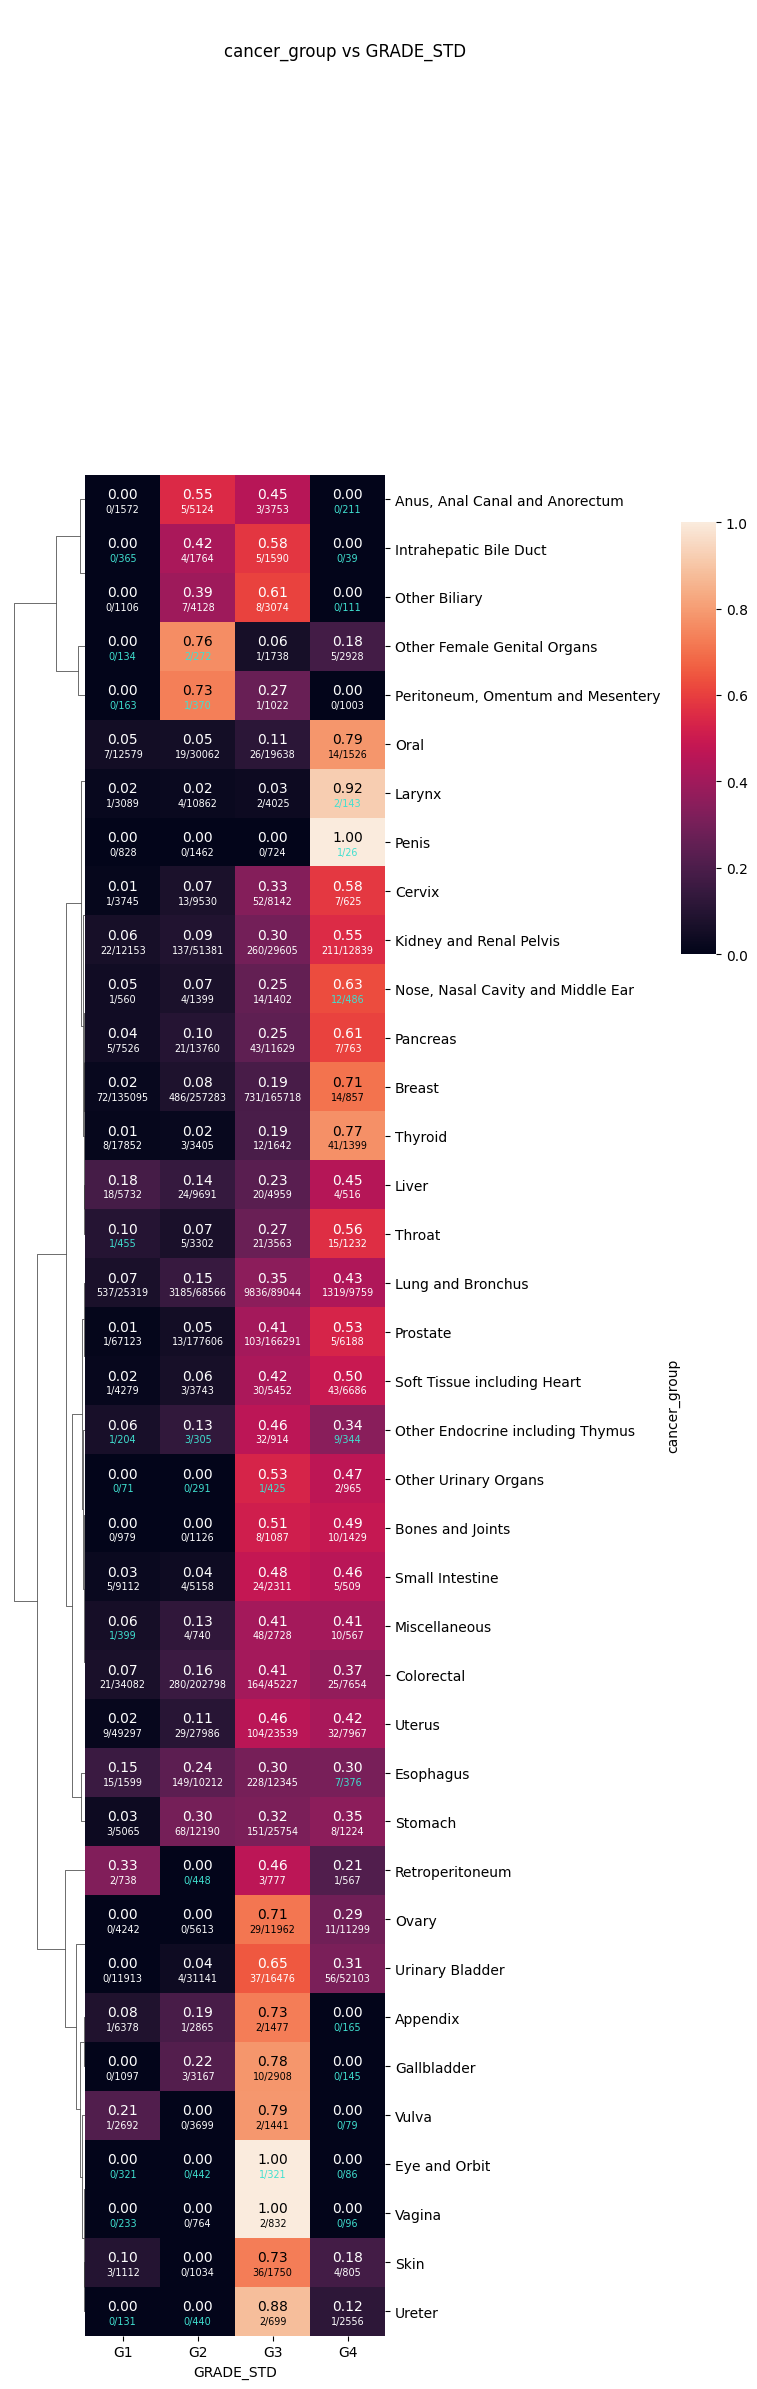

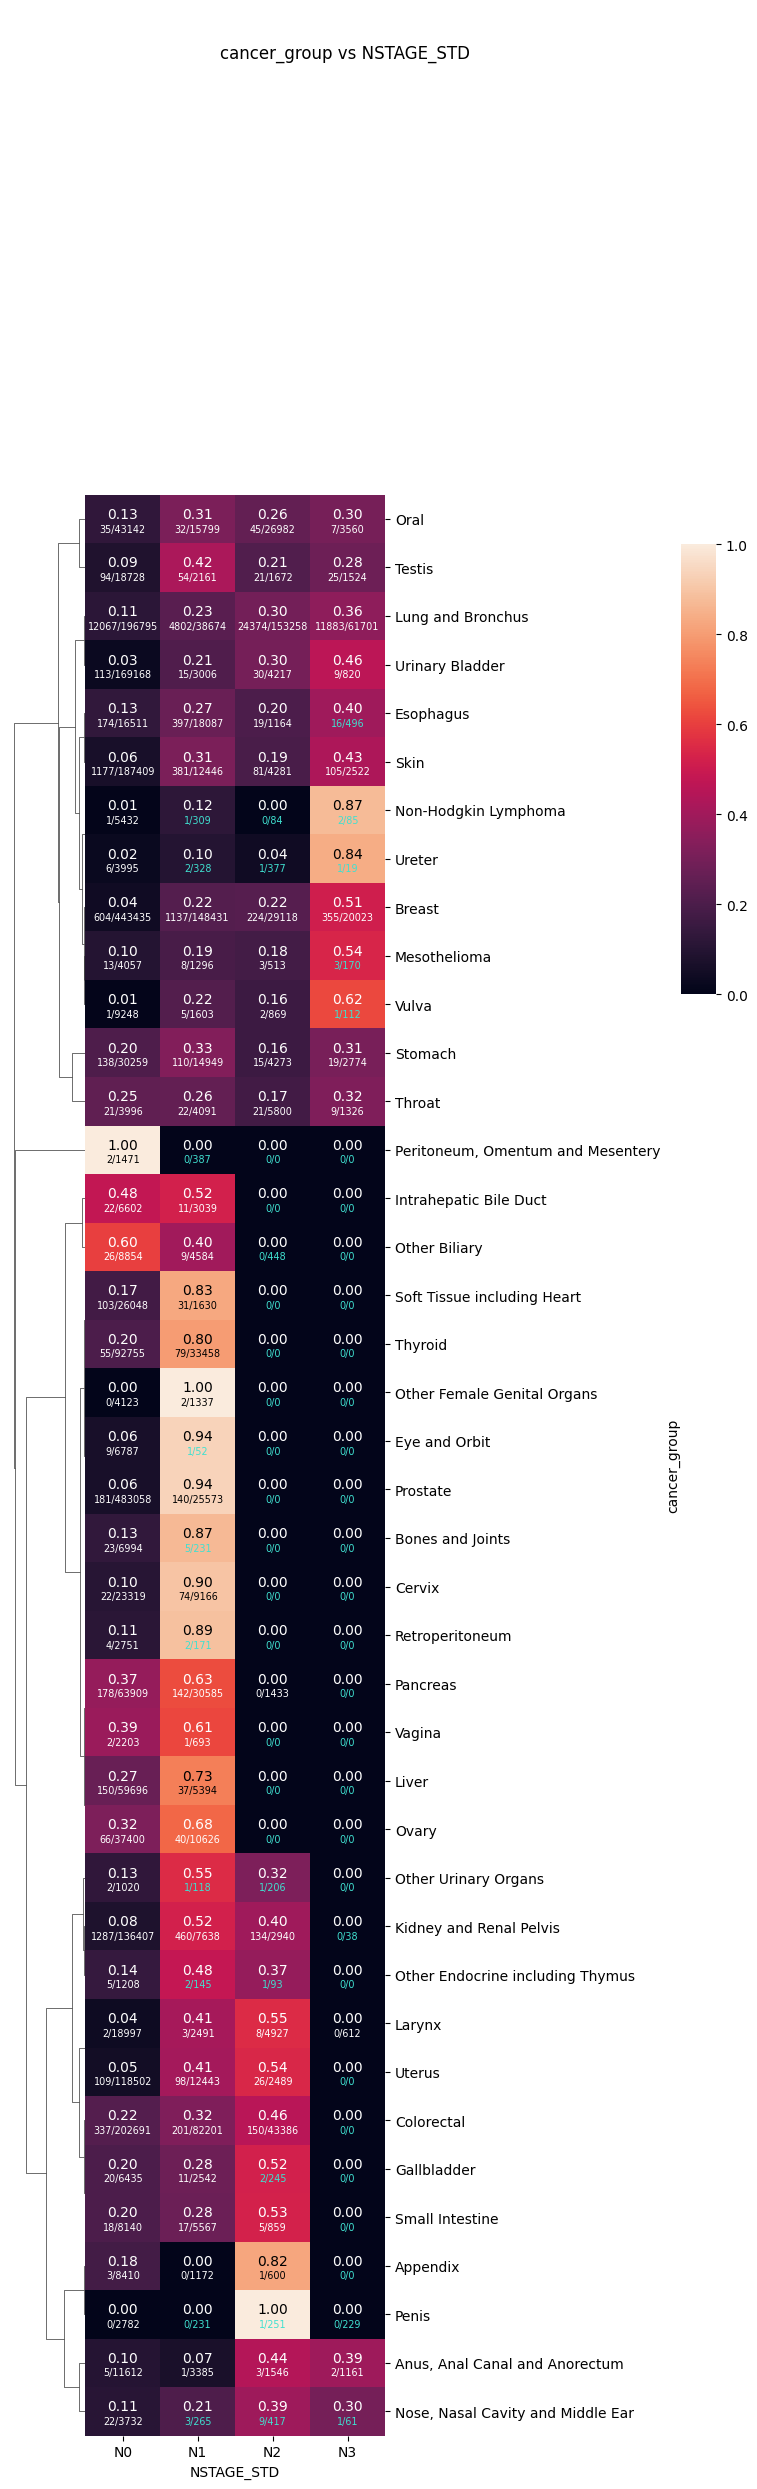

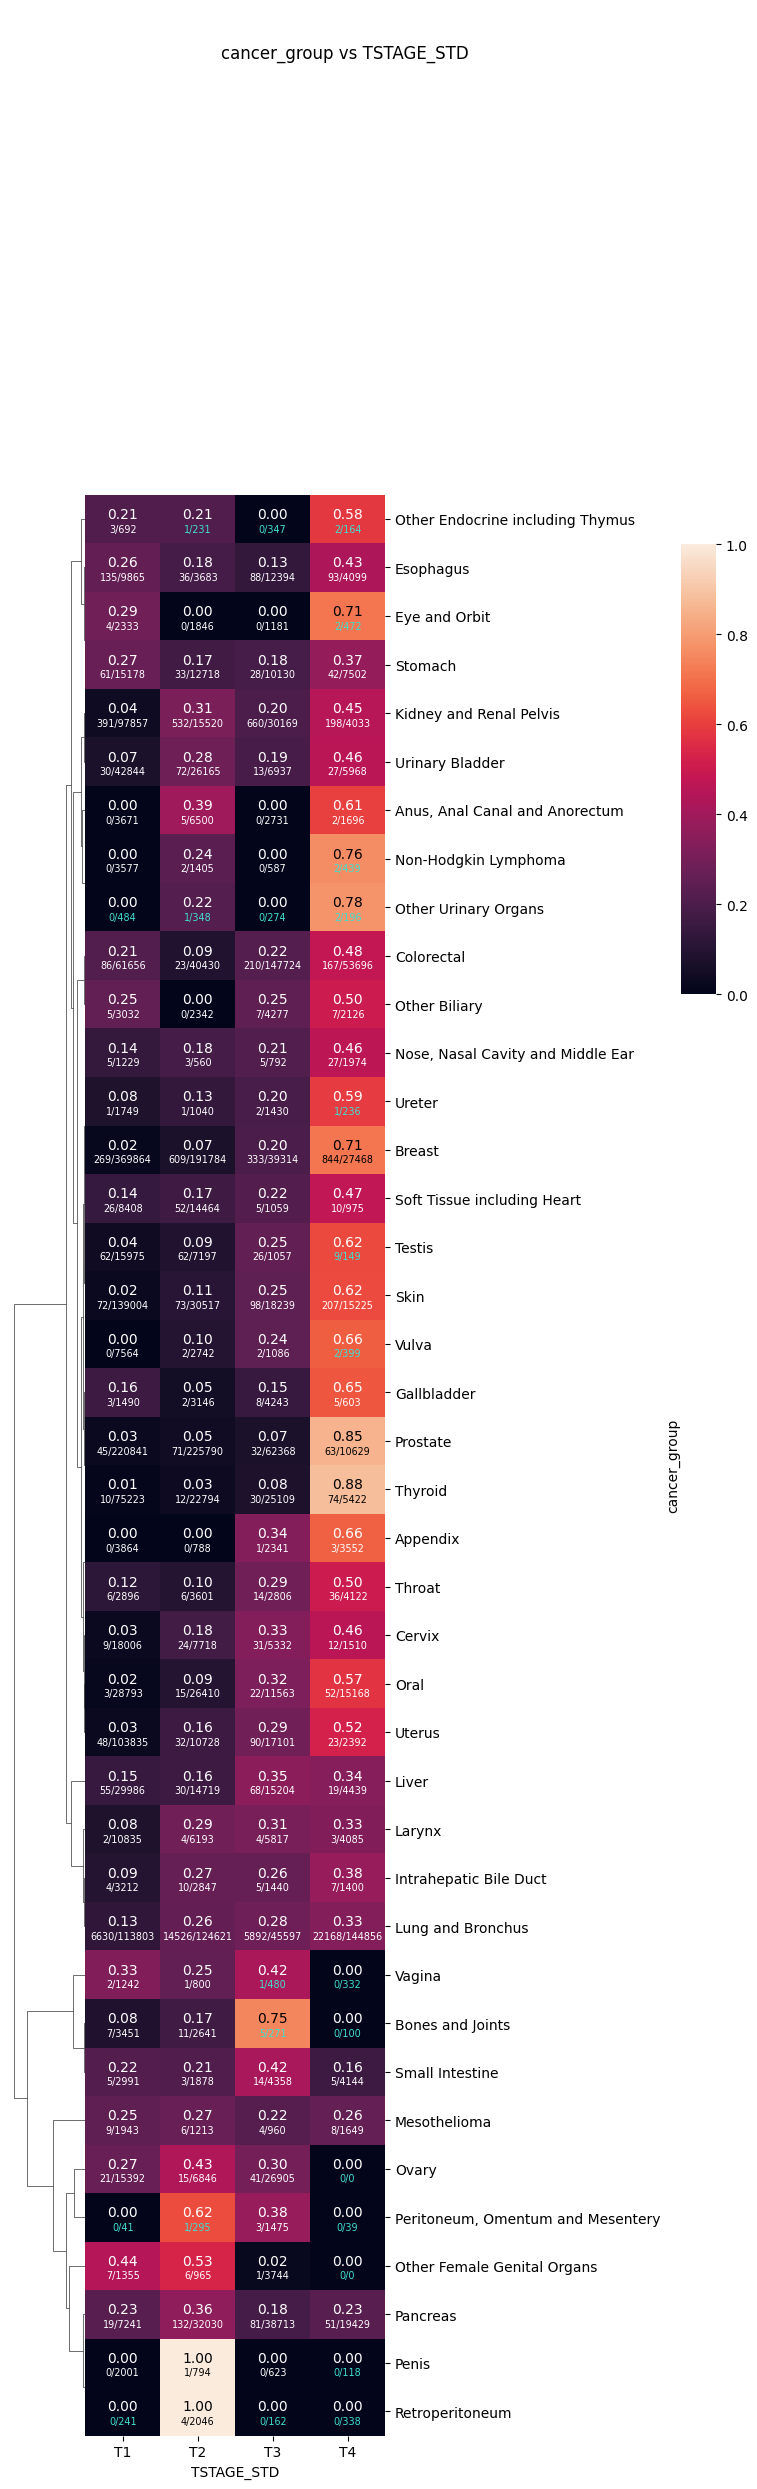

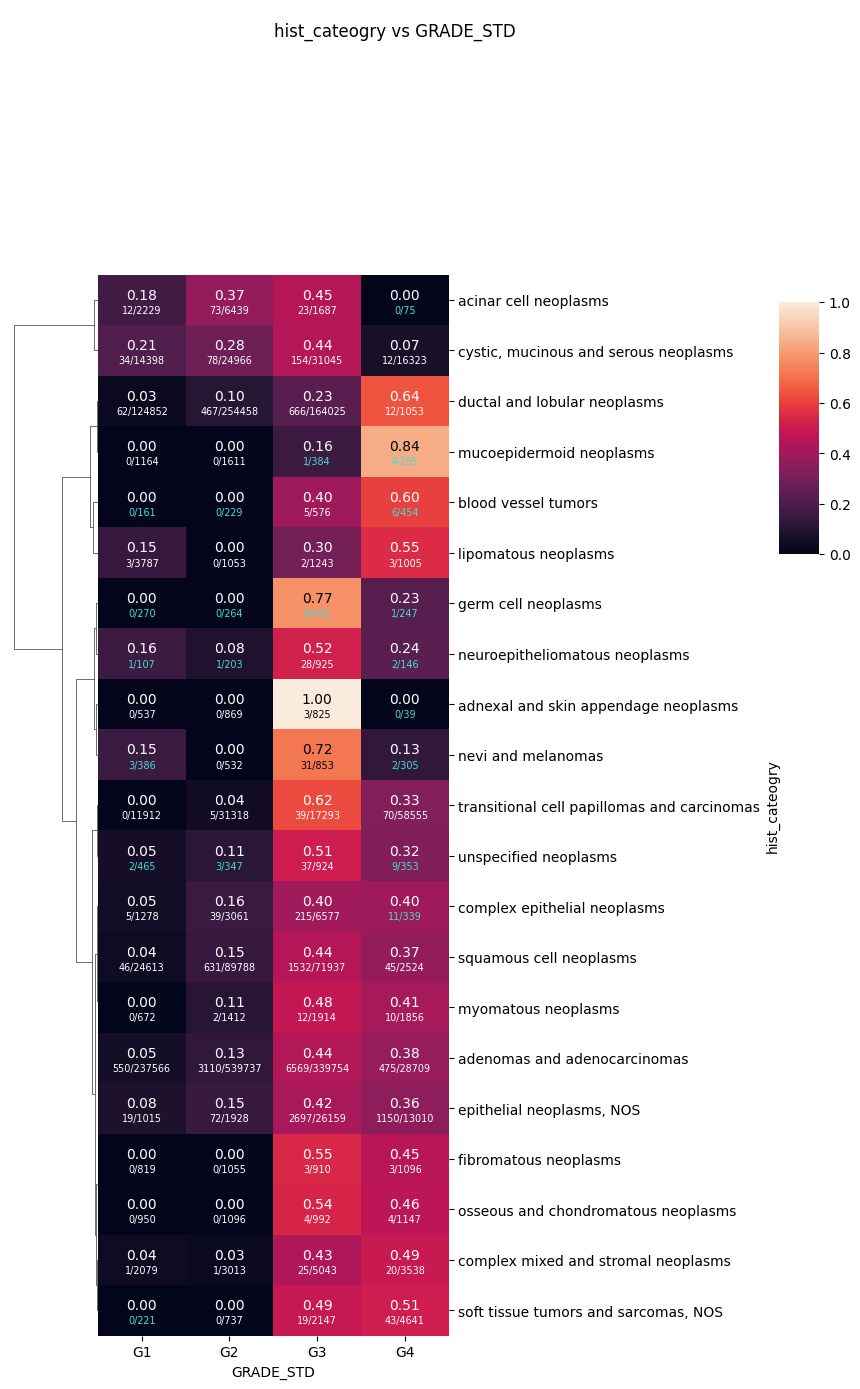

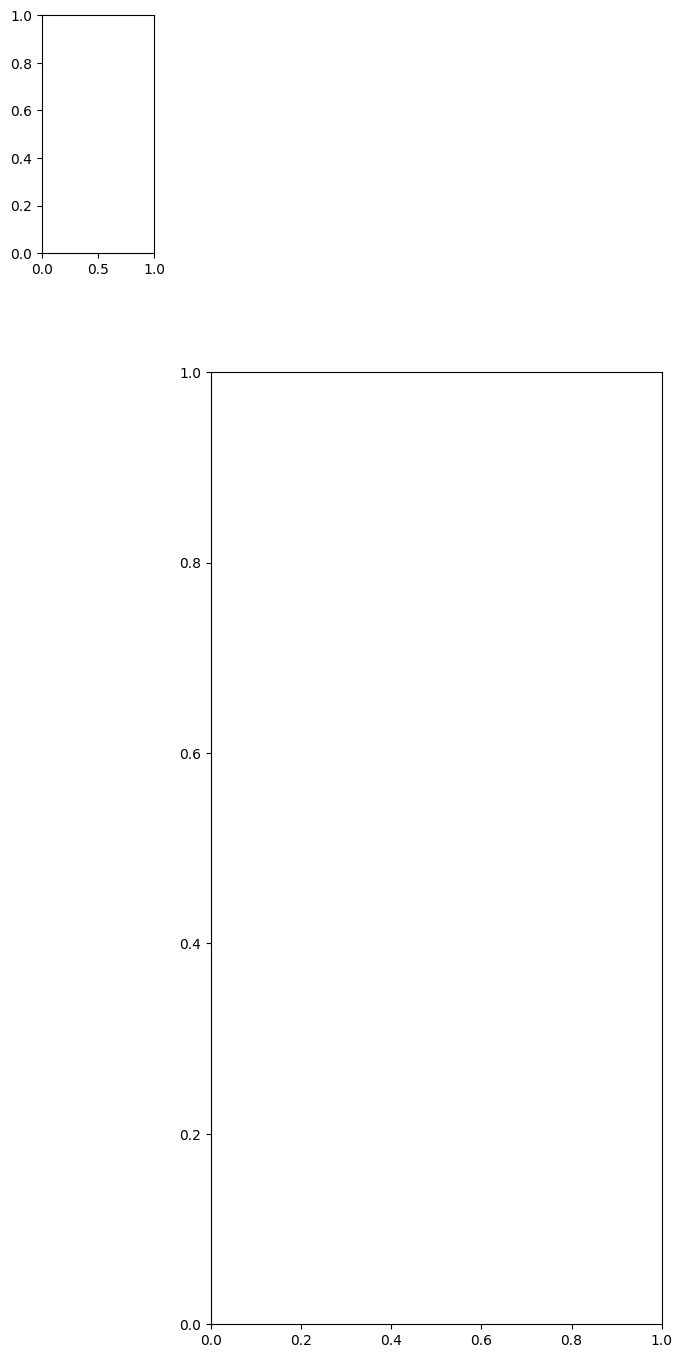

In [268]:

###############
### GENERAL ###
###############
print('\n\n--- GENERAL ---\n')
do_prevalence_clustermaps(
    group_fields=['cancer_group', 'hist_cateogry'], 
    feature_fields=['GRADE_STD', 'NSTAGE_STD', 'TSTAGE_STD'], 
    df=df
)

##############
### BREAST ###
##############
print('\n\n--- BREAST ---\n')
breast_df = df[df['cancer_group']=='Breast']

do_prevalence_clustermaps(
    group_fields=['breast_subtype', 'hist_cateogry'], 
    feature_fields=['GRADE_STD', 'NSTAGE_STD', 'TSTAGE_STD'], 
    df=breast_df,
    subdir_override='breast'
)

################
### PROSTATE ###
################
print('\n\n--- PROSTATE ---\n')
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
prostate_df = df[df['cancer_group']=='Prostate']
prostate_df['psa_bin'] = pd.cut(prostate_df['psa'], bins).astype(str)

# PSA value to bins
do_prevalence_clustermaps(
    group_fields=['hist_cateogry', 'hist_type_descr'], 
    feature_fields=['psa_bin'], 
    df=prostate_df,
    subdir_override='prostate'
)
do_prevalence_clustermaps(
    group_fields=['psa_bin'], 
    feature_fields=['GRADE_STD', 'NSTAGE_STD', 'TSTAGE_STD'], 
    df=prostate_df,
    subdir_override='prostate'
)


In [ ]:
from util_maps import CGROUPS_NSTAGES_N0N1
from util_maps import CGROUPS_NSTAGES_N0N1N2
from util_maps import CGROUPS_NSTAGES_N0N1N2N3

"""
groups 
- cancer_type
- cancer_group
- hist_type
- hist_cateogry
Features
- TSTAGE_STD
- NSTAGE_STD
- GRADE_STD
- diagnosis_agebin
- diagnosis_year
- breast_subtype
"""

NORM_FIELD = 'norm'
NORM_METH = 'sum'


feature_fields = ['GRADE_STD', 'NSTAGE_STD']
group_fields = ['breast_subtype']
MIN_RECORDS = 10000

breast_df = df[df['cancer_group']=='Breast']
prostate_df = df[df['cancer_group']=='Prostate']
maintable = calculate_bm_prevalence_grouped(
    groups=group_fields, 
    features=feature_fields, 
    min_records=MIN_RECORDS,
    df=breast_df,
    # df=df[df[GROUP_FIELD].isin(CGROUPS_NSTAGES_N0N1N2N3)],
    # groups_subset=['Breast'],
    # features_subset={'GRADE_STD': ['G1', 'G2', 'G3', 'G4']},
    # features_subset={'NSTAGE_STD': ['N0', 'N1']},
)

In [ ]:
maintable = normalize_field_pergroup(
    groups=COMPOUND_GROUP,
    targetfield=RATE_FIELD, 
    normfield=NORM_FIELD, 
    df=maintable, 
    meth=NORM_METH
)

maintable_p = maintable.pivot(index=COMPOUND_GROUP, columns=COMPOUND_FEATURE, values=NORM_FIELD)
maintable_p = maintable_p.fillna(0)
maintable_p = maintable_p.reindex(sorted(maintable_p.columns), axis=1)

ROW_CLUSTER = True
COL_CLUSTER = False
max_value = maintable_p.to_numpy().max()

max_group_label_len = max([len(x) for x in maintable_p.index])
max_feature_label_len = max([len(x) for x in maintable_p.columns])
figx = maintable_p.shape[1] // 2 + max_group_label_len // 8 + 1
figy = maintable_p.shape[0] // 1.7 + max_feature_label_len // 8 + 2

cm = sns.clustermap(
    maintable_p, 
    figsize=(figx, figy), 
    # cbar_pos=None,
    cbar_pos=(0.98, 0.6, 0.05, 0.18),
    col_cluster=COL_CLUSTER, 
    row_cluster=ROW_CLUSTER, 
    metric="euclidean",
    square=True
)
rowinds = cm.dendrogram_row.reordered_ind if ROW_CLUSTER else list(range(maintable_p.shape[0]))
colinds = cm.dendrogram_col.reordered_ind if COL_CLUSTER else list(range(maintable_p.shape[1]))
for y, ridx in enumerate(rowinds): 
    for x, cidx in enumerate(colinds): 
        rlabel = maintable_p.index[ridx]
        clabel = maintable_p.columns[cidx]
        row = maintable.loc[(maintable[COMPOUND_GROUP]==rlabel) & (maintable[COMPOUND_FEATURE]==clabel)]
        if row.shape[0] == 0:
            normval, num_bm, num_cases = 0, 0, 0
        else:
            normval = row[NORM_FIELD].values[0]
            num_bm = row["YES"].values[0]
            num_cases = row["records"].values[0]
        line1 = f'{normval:0.2f}'
        line2 = f'{num_bm}/{num_cases}'
        color1 = 'white' if normval < (max_value * 0.7) else 'black'
        color2 = color1 if num_cases >= 500 else 'turquoise'
        cm.ax_heatmap.text(x+0.5, y+0.4, line1, va="center", ha="center", color=color1, fontsize='medium')
        cm.ax_heatmap.text(x+0.5, y+0.7, line2, va="center", ha="center", color=color2, fontsize='x-small')

# SUFFIX = '_N0N1N2N3_tissues'
# SUBSET = 'prostate_'
SUFFIX = ''
SUBSET = 'breast'
group = ':'.join(group_fields)
feature = ':'.join(feature_fields)
filename = f'/home/grace/work/SEER/outputs/clustermaps/{SUBSET}_{group}_{feature}{SUFFIX}.png'
title = f'{group} vs {feature}'
cm.ax_heatmap.set_xlabel(feature)
cm.ax_heatmap.set_ylabel(group)
plt.suptitle(title)
plt.savefig(filename)


<br>
<br>
<br>
<br>
<br>
<br>
<br>

In [ ]:

def do_barplot(feature: str, df: pd.DataFrame, subset: Optional[dict]=None) -> None:
    temp = df.dropna(subset=[feature])
    if subset is not None:
        for field, vlist in subset.items():
            temp = temp[df[field].isin(vlist)]
    temp = temp[[feature, 'brain_met']]
    prevs = calculate_bm_prevalence(feature, temp)
    prevs = prevs.sort_values(by=feature)

    # ax = sns.barplot(prevs, x=feature, y=RATE_FIELD)
    # ax.bar_label(ax.containers[0], labels=prevs[NUM_RECORDS_FIELD])
    ax = sns.barplot(prevs, x=feature, y=RATE_FIELD, hue=feature)
    for index, row in prevs.iterrows():
        ax.text(row[feature], row[RATE_FIELD]+0.1, row['records'], color='black', ha='center')
        # ax.text(row[feature], row[RATE_FIELD], round(row[feature], 2), color='black', ha='center')
    
    # title
    title = f'{feature} vs brain metastasis'
    plt.suptitle(title)
    if subset is not None:
        subtitle = '\n'.join([f'{k}=={v}' for k, v in subset.items()])
        plt.title(subtitle)

    plt.show()

def plot_boxplot(feature: str, response: str, maintable: pd.DataFrame, ylims: Optional[Tuple]=None) -> None:
    sns.boxplot(data=maintable, x=feature, y=response, hue=feature)
    if ylims:
        plt.ylim(ylims[0], ylims[1])
    plt.show()

def plot_violin(feature: str, response: str, maintable: pd.DataFrame, ylims: Optional[Tuple]=None) -> None:
    sns.violinplot(data=maintable, x=feature, y=response, hue=feature)
    if ylims:
        plt.ylim(ylims[0], ylims[1])
    plt.show()


In [ ]:

do_barplot('NSTAGE_STD', df)
do_barplot('NSTAGE_STD', df, subset={'cancer_type': ['Breast']})
do_barplot('NSTAGE_STD', df, subset={'cancer_type': ['Lung and Bronchus']})

In [ ]:
maintable = calculate_bm_prevalence_grouped('cancer_type', 'NTSTAGE_STD', df)

In [ ]:

FEATURE_FIELD = 'NSTAGE_STD'
RATE_FIELD_NORM = RATE_FIELD + ' [NORM]'
maintable = calculate_bm_prevalence_grouped('cancer_type', FEATURE_FIELD, df)
maintable = normalize_field_pergroup('cancer_type', RATE_FIELD, RATE_FIELD_NORM, maintable)

plot_boxplot(FEATURE_FIELD, RATE_FIELD, maintable)
plot_boxplot(FEATURE_FIELD, RATE_FIELD, maintable, ylims=(-1,4))
plot_violin(FEATURE_FIELD, RATE_FIELD_NORM, maintable)


In [ ]:
fig, ax = plt.subplots()
labels = maintable[maintable['cancer_type']=='Lung and Bronchus'][FEATURE_FIELD]
sizes = maintable[maintable['cancer_type']=='Lung and Bronchus'][NORM_FIELD]
ax.pie(sizes, labels=labels, autopct='%1.1f%%')

In [ ]:
FEATURE_FIELD = 'NSTAGE_STD'
NORM_FIELD = 'norm'
NORM_METH = 'sum'
maintable = normalize_field_pergroup(
    groupsfield='cancer_type', 
    targetfield=RATE_FIELD, 
    normfield=NORM_FIELD, 
    df=maintable, 
    meth=NORM_METH
)

NSTAGE_IGNORES = [
    'NHL - Extranodal', 
    'NHL - Nodal', 
    'Hodgkin - Extranodal', 
    'Hodgkin - Nodal'
]
N0N1_OVERRIDES = ['Pancreas', 'Other Biliary']

# create pivot
maintable_p = maintable.pivot(index='cancer_type', columns=FEATURE_FIELD, values=NORM_FIELD)

# remove some cancer types
maintable_p = maintable_p.drop(index=NSTAGE_IGNORES, errors='ignore')

# print(maintable_p.shape)
# print(maintable_p)

# 2 N-stage categories
maintable_p_N0N1 = maintable_p[(maintable_p['N2'].isna()) & (maintable_p['N3'].isna())].drop(columns=['N2', 'N3'])
print(maintable_p_N0N1.shape)
print(maintable_p_N0N1)

# (handle overrides)
# maintable_p_N0N1_overrides = maintable_p[maintable_p['cancer_type'].isin(N0N1_OVERRIDES)].drop(columns=['N2', 'N3'])
maintable_p_N0N1_overrides = maintable_p.loc[N0N1_OVERRIDES].drop(columns=['N2', 'N3'])
maintable_p_N0N1 = pd.concat([maintable_p_N0N1, maintable_p_N0N1_overrides])
maintable_p = maintable_p.drop(index=N0N1_OVERRIDES, errors='ignore')

# 3 N-stage categories
maintable_p_N0N1N2 = maintable_p[(maintable_p['N2'].notna()) & (maintable_p['N3'].isna())].drop(columns=['N3'])

# 4 N-stage categories
maintable_p_N0N1N2N3 = maintable_p.dropna()

# print('\nLip & Penis')
# print(maintable[maintable['cancer_type'].isin(['Lip', 'Penis'])])
# print('\nAppendix & Splenic Flexure')
# print(maintable[maintable['cancer_type'].isin(['Appendix', 'Splenic Flexure'])])

# print('\nN0N1N2')
# print(maintable_p_N0N1N2.shape)
# print(maintable_p_N0N1N2)

sns.clustermap(maintable_p_N0N1, annot=True, fmt=".2f", col_cluster=False, figsize=(5, 8), cbar_pos=(0.98, 0.6, 0.05, 0.18))
sns.clustermap(maintable_p_N0N1N2, annot=True, fmt=".2f", col_cluster=False, figsize=(5, 10), cbar_pos=(0.98, 0.6, 0.05, 0.18))
sns.clustermap(maintable_p_N0N1N2N3, annot=True, fmt=".2f", col_cluster=False, figsize=(5, 13), cbar_pos=(0.98, 0.6, 0.05, 0.18))

# fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 8), gridspec_kw={'width_ratios':[5,6,7]}, layout="compressed")
# sns.clustermap(maintable_p_N0N1, ax=ax1)
# sns.clustermap(maintable_p_N0N1N2, ax=ax2)
# sns.clustermap(maintable_p_N0N1N2N3, ax=ax3)
# plt.show()

In [ ]:
maintable_ctype = calculate_bm_prevalence_grouped('cancer_type', FEATURE_FIELD, df)
maintable_cgroup = calculate_bm_prevalence_grouped('cancer_group', FEATURE_FIELD, df)


In [ ]:
FEATURE_FIELD = 'NSTAGE_STD'
GROUP_FIELD = 'cancer_group'
NORM_FIELD = 'norm'
NORM_METH = 'sum'
# COMMONS = [
#     'Lung and Bronchus',
#     'Melanoma of the Skin',
#     'Other Non-Epithelial Skin',
#     'Kidney and Renal Pelvis',
#     'Esophagus',
#     'Breast',
# ]
COMMONS = [
    'Lung and Bronchus',
    'Skin',
    'Kidney and Renal Pelvis',
    'Esophagus',
    'Colorectal',
    'Breast',
]
UNCOMMONS = [
    'Prostate'
]
maintable = calculate_bm_prevalence_grouped(GROUP_FIELD, FEATURE_FIELD, df)
maintable = normalize_field_pergroup(GROUP_FIELD, RATE_FIELD, NORM_FIELD, maintable)
maintable_p = maintable.pivot(index=GROUP_FIELD, columns=FEATURE_FIELD, values=NORM_FIELD)
print(maintable)
maintable_p = maintable_p.fillna(0)

# maintable_p = maintable_p.loc[COMMONS + UNCOMMONS]
sns.clustermap(maintable_p, annot=True, fmt=".2f", col_cluster=False, figsize=(6, 22), cbar_pos=(0.98, 0.6, 0.05, 0.18))
filename = f'/home/grace/work/SEER/outputs/clustermaps/{GROUP_FIELD}_{FEATURE_FIELD}.png'
title = f'{GROUP_FIELD} vs {FEATURE_FIELD}'
plt.suptitle(title)
plt.savefig(filename)

ASKDmAOKSDj

In [ ]:
titanic = sns.load_dataset("titanic")
sns.violinplot(data=titanic, x="age", y="class")
titanic.head()